# Activities 9.1 and 9.2 – Random Sampler & Random Walk

Analysis and Design of Advanced Algorithms

Group #607

Team 1

Luis Salomón Flores Ugalde

Santiago Quintana Moreno A01571222

Miguel Ángel Álvarez Hermida A01722925

In [2]:

import random
import math
from dataclasses import dataclass
from typing import List, Tuple, Callable, Dict
import matplotlib.pyplot as plt
import numpy as np

# For small tabular display
try:
    import pandas as pd
except ImportError:
    pd = None

Edge = Tuple[int, int]  # (u, v) with 0-based node indices


## 1. Graph loading utilities

In [3]:

def load_graph(path: str) -> Tuple[int, List[Edge]]:
    """Load a graph from the given text file.

    Expected formats:
    - First non-comment line: `n m`  (or `n something m`)
    - Subsequent lines: `u v` edges, 1-based or 0-based indices.
    - Some files start with a line like 'Nombre del problema: ...' which we skip.
    """
    n = None
    header_read = False
    edges: List[Edge] = []

    with open(path, "r", encoding="utf-8") as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            if line.startswith("#"):
                continue
            if line.lower().startswith("nombre"):
                # Skip Spanish header lines like 'Nombre del problema: ...'
                continue

            parts = line.split()
            # Try to parse everything as ints; if fails, skip
            try:
                nums = [int(p) for p in parts]
            except ValueError:
                continue

            if not header_read:
                # Header line: only first number (n) matters for us
                n = nums[0]
                header_read = True
            else:
                if len(nums) >= 2:
                    u, v = nums[0], nums[1]
                    edges.append((u, v))

    if n is None:
        # Fallback: infer n from edges
        if not edges:
            raise ValueError(f"Could not infer number of nodes from file {path}")
        n = max(max(u, v) for u, v in edges) + 1

    # Check if graph is 0-based or 1-based
    min_node = min(min(u, v) for u, v in edges) if edges else 0
    
    if min_node == 0:
        # Graph is already 0-based, use as-is
        return n, edges
    else:
        # Graph is 1-based, convert to 0-based
        edges_0based = [(u - 1, v - 1) for u, v in edges]
        return n, edges_0based


# Quick sanity check on the example graph (will fail if file is not present yet)
try:
    n_example, edges_example = load_graph("grafo-pres-24-1.txt")
    print(f"Loaded grafo-pres-24-1.txt with n={n_example}, |E|={len(edges_example)}")
except FileNotFoundError:
    print("⚠️ Place 'grafo-pres-24-1.txt' next to this notebook to load the example graph.")


Loaded grafo-pres-24-1.txt with n=9, |E|=11


## 2. Bandwidth-type objective functions

In [4]:

def _positions_from_perm(perm):
    """Return a dict node -> position index for a permutation."""
    return {node: idx for idx, node in enumerate(perm)}


def bandwidth_cost(perm: List[int], edges: List[Edge]) -> int:
    pos = _positions_from_perm(perm)
    return max(abs(pos[u] - pos[v]) for u, v in edges)


def bandwidth_sum_cost(perm: List[int], edges: List[Edge]) -> int:
    pos = _positions_from_perm(perm)
    return sum(abs(pos[u] - pos[v]) for u, v in edges)


def antibandwidth_cost(perm: List[int], edges: List[Edge]) -> int:
    pos = _positions_from_perm(perm)
    return min(abs(pos[u] - pos[v]) for u, v in edges)


## 3. Activity 9.1 – Random Sampler for Bandwidth

In [5]:

def random_sampler_bandwidth(n: int, edges: List[Edge], iterations: int = 100, seed: int = None):
    if seed is not None:
        random.seed(seed)

    results = [] 

    for _ in range(iterations):
        perm = list(range(n))
        random.shuffle(perm)
        cost = bandwidth_cost(perm, edges)
        results.append((perm, cost))

    best_perm, best_cost = min(results, key=lambda t: t[1])
    worst_perm, worst_cost = max(results, key=lambda t: t[1])

    return {
        "results": results,
        "best_perm": best_perm,
        "best_cost": best_cost,
        "worst_perm": worst_perm,
        "worst_cost": worst_cost,
    }


try:
    n_g, edges_g = load_graph("grafo-pres-24-1.txt")
    sampler_out = random_sampler_bandwidth(n_g, edges_g, iterations=100, seed=42)

    print("Best bandwidth found:", sampler_out["best_cost"])
    print("Best permutation (0-based):", sampler_out["best_perm"])
    print()
    print("Worst bandwidth found:", sampler_out["worst_cost"])
    print("Worst permutation (0-based):", sampler_out["worst_perm"])

    if pd is not None:
        df = pd.DataFrame(
            [
                {
                    "iteration": i,
                    "bandwidth": cost,
                    "perm": perm,
                }
                for i, (perm, cost) in enumerate(sampler_out["results"])
            ]
        )
        display(df.head())
    else:
        print("\n(Pandas not installed – skipping table.)")

except FileNotFoundError:
    print("Example graph file 'grafo-pres-24-1.txt' not found. Place it next to this notebook.")


Best bandwidth found: 4
Best permutation (0-based): [8, 2, 6, 1, 3, 4, 7, 0, 5]

Worst bandwidth found: 8
Worst permutation (0-based): [3, 6, 7, 4, 8, 2, 5, 0, 1]

(Pandas not installed – skipping table.)


### 3.1 Activity 9.1 questions

**Q1. How could this algorithm be improved to produce better solutions with the same number of iterations?**

- Use smarter initial permutations.
- Use heuristics that place high-degree vertices near the center.
- Combine random sampling with local search.
- Bias the randomness.

**Q2. How many possible solutions are there?**

- With n vertices, every permutation of the labels is a candidate solution  n! permutations.

**Q3. What is the difficulty of the problem (not of this algorithm)?**

- The bandwidth minimization problem is known to be NP‑hard, so no polynomial‑time algorithm is known (or expected) to always find the optimal solution on large instances.

## 4. Random Walk framework for permutations

In [6]:
def two_swap(perm: List[int]) -> List[int]:
    i, j = random.sample(range(len(perm)), 2)
    new_perm = perm.copy()
    new_perm[i], new_perm[j] = new_perm[j], new_perm[i]
    return new_perm


def random_walk_permutation(
    n: int,
    edges: List[Edge],
    eval_fn: Callable[[List[int], List[Edge]], float],
    steps: int,
    minimize: bool,
    seed: int = None,
):

    if seed is not None:
        random.seed(seed)

    current = list(range(n))
    random.shuffle(current)
    current_cost = eval_fn(current, edges)

    best = current[:]
    best_cost = current_cost

    for _ in range(steps):
        neighbor = two_swap(current)
        neigh_cost = eval_fn(neighbor, edges)

        current, current_cost = neighbor, neigh_cost

        if minimize:
            if neigh_cost < best_cost:
                best, best_cost = neighbor, neigh_cost
        else:
            if neigh_cost > best_cost:
                best, best_cost = neighbor, neigh_cost

    return best, best_cost


## 5. Activity 9.2 – Random Walk for bandwidth sum and anti‑bandwidth

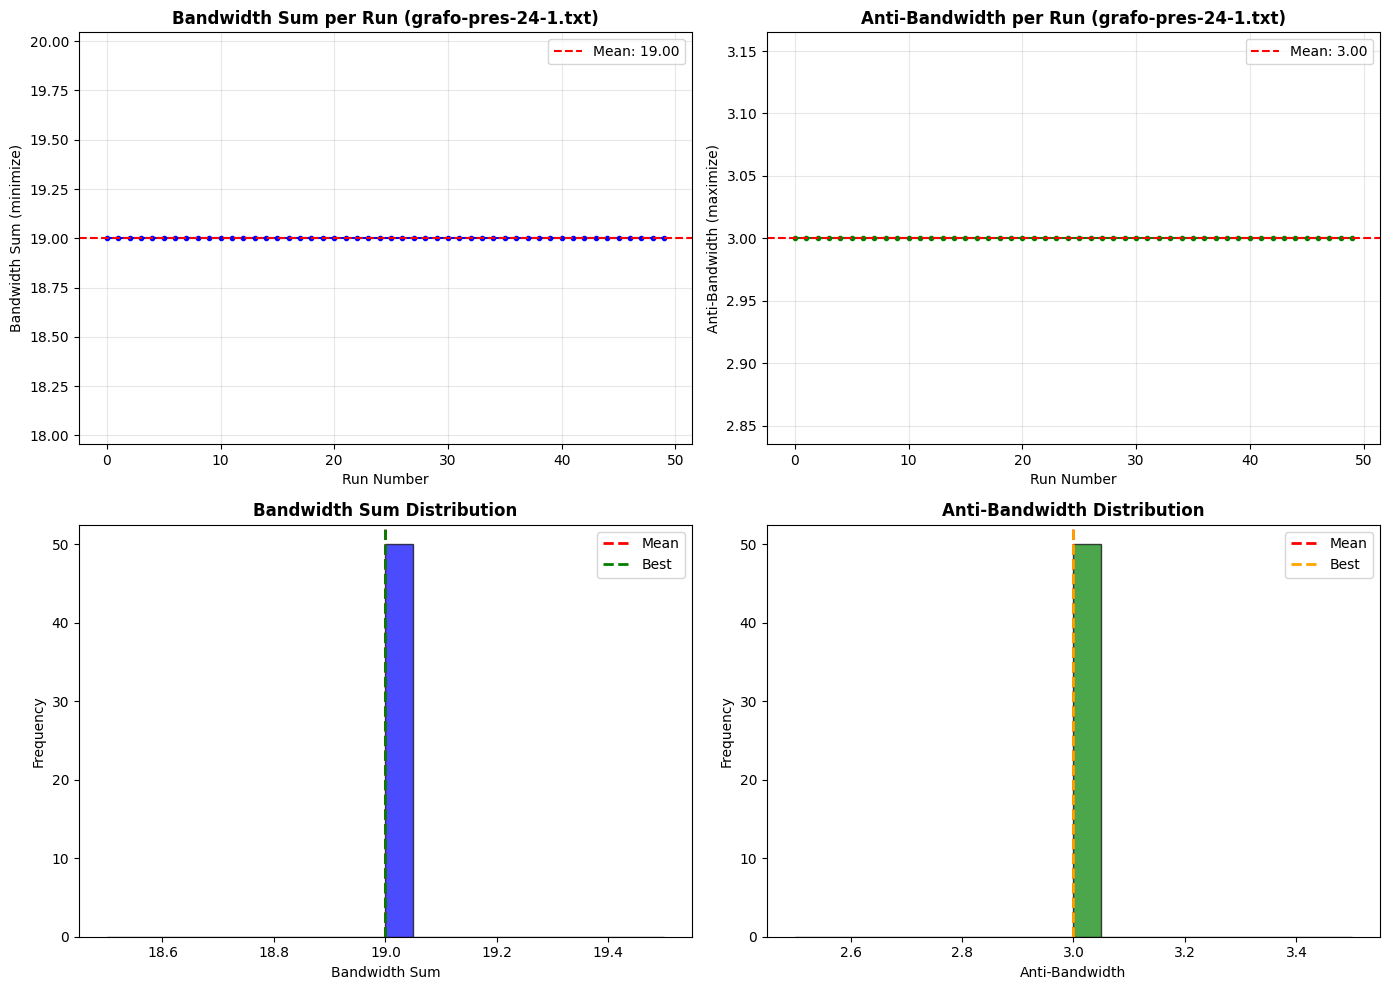


SUMMARY STATISTICS - grafo-pres-24-1.txt
Best        : BW Sum =    19.00, Anti-BW =     3.00
Worst       : BW Sum =    19.00, Anti-BW =     3.00
Mean        : BW Sum =    19.00, Anti-BW =     3.00
Std Dev     : BW Sum =     0.00, Anti-BW =     0.00
Median      : BW Sum =    19.00, Anti-BW =     3.00


In [ ]:
@dataclass
class WalkResult:
    run_id: int
    problem: str
    graph_name: str
    best_cost: float
    best_perm: List[int]


def run_bandwidth_walks(
    graph_path: str,
    steps: int = 100_000,
    runs: int = 50,
    seed: int = 0,
):
    n, edges = load_graph(graph_path)
    base_name = graph_path

    results: List[WalkResult] = []
    rng = random.Random(seed)

    for run in range(runs):
        run_seed = rng.randint(0, 10**9)

        best_perm_sum, best_cost_sum = random_walk_permutation(
            n, edges, bandwidth_sum_cost, steps, minimize=True, seed=run_seed
        )
        results.append(
            WalkResult(run, "bandwidth_sum", base_name, best_cost_sum, best_perm_sum)
        )

        best_perm_anti, best_cost_anti = random_walk_permutation(
            n, edges, antibandwidth_cost, steps, minimize=False, seed=run_seed + 1
        )
        results.append(
            WalkResult(run, "anti_bandwidth", base_name, best_cost_anti, best_perm_anti)
        )

    bw_sum_costs = [r.best_cost for r in results if r.problem == "bandwidth_sum"]
    anti_bw_costs = [r.best_cost for r in results if r.problem == "anti_bandwidth"]
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Bandwidth Sum - Line plot
    axes[0, 0].plot(range(len(bw_sum_costs)), bw_sum_costs, 'b-', marker='o', markersize=3)
    axes[0, 0].set_title(f'Bandwidth Sum per Run ({base_name})', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Run Number')
    axes[0, 0].set_ylabel('Bandwidth Sum (minimize)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=np.mean(bw_sum_costs), color='r', linestyle='--', label=f'Mean: {np.mean(bw_sum_costs):.2f}')
    axes[0, 0].legend()
    
    # 2. Anti-Bandwidth - Line plot
    axes[0, 1].plot(range(len(anti_bw_costs)), anti_bw_costs, 'g-', marker='o', markersize=3)
    axes[0, 1].set_title(f'Anti-Bandwidth per Run ({base_name})', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Run Number')
    axes[0, 1].set_ylabel('Anti-Bandwidth (maximize)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(y=np.mean(anti_bw_costs), color='r', linestyle='--', label=f'Mean: {np.mean(anti_bw_costs):.2f}')
    axes[0, 1].legend()
    
    # 3. Bandwidth Sum - Histogram
    axes[1, 0].hist(bw_sum_costs, bins=20, color='blue', alpha=0.7, edgecolor='black')
    axes[1, 0].set_title('Bandwidth Sum Distribution', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Bandwidth Sum')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(x=np.mean(bw_sum_costs), color='r', linestyle='--', linewidth=2, label='Mean')
    axes[1, 0].axvline(x=np.min(bw_sum_costs), color='g', linestyle='--', linewidth=2, label='Best')
    axes[1, 0].legend()
    
    # 4. Anti-Bandwidth - Histogram
    axes[1, 1].hist(anti_bw_costs, bins=20, color='green', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Anti-Bandwidth Distribution', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Anti-Bandwidth')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(x=np.mean(anti_bw_costs), color='r', linestyle='--', linewidth=2, label='Mean')
    axes[1, 1].axvline(x=np.max(anti_bw_costs), color='orange', linestyle='--', linewidth=2, label='Best')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    stats_data = {
        'Metric': ['Best', 'Worst', 'Mean', 'Std Dev', 'Median'],
        'Bandwidth Sum': [
            np.min(bw_sum_costs),
            np.max(bw_sum_costs),
            np.mean(bw_sum_costs),
            np.std(bw_sum_costs),
            np.median(bw_sum_costs)
        ],
        'Anti-Bandwidth': [
            np.max(anti_bw_costs),
            np.min(anti_bw_costs),
            np.mean(anti_bw_costs),
            np.std(anti_bw_costs),
            np.median(anti_bw_costs)
        ]
    }
    
    if pd is not None:
        stats_df = pd.DataFrame(stats_data)
        print("\n" + "="*60)
        print(f"SUMMARY STATISTICS - {base_name}")
        print("="*60)
        display(stats_df)
    else:
        print("\n" + "="*60)
        print(f"SUMMARY STATISTICS - {base_name}")
        print("="*60)
        for i, metric in enumerate(stats_data['Metric']):
            print(f"{metric:12s}: BW Sum = {stats_data['Bandwidth Sum'][i]:8.2f}, Anti-BW = {stats_data['Anti-Bandwidth'][i]:8.2f}")
    
    return results


results_example = run_bandwidth_walks("grafo-pres-24-1.txt")


## 6. Activity 9.2 – Random Walk for Knapsack

In [8]:

# Example knapsack instance (you can replace these with your own)
values_example = [20, 30, 35, 12, 3, 80, 25, 50, 45, 15]
weights_example = [2, 5, 7, 3, 1, 10, 4, 9, 6, 2]
capacity_example = 25  # total allowed weight


def random_feasible_knapsack_solution(values, weights, capacity, rng: random.Random):
    """Greedy-random construction of a feasible knapsack solution."""
    n = len(values)
    indices = list(range(n))
    rng.shuffle(indices)

    x = [0] * n
    total_w = 0

    for i in indices:
        if total_w + weights[i] <= capacity:
            x[i] = 1
            total_w += weights[i]
    return x


def knapsack_value_weight(x, values, weights):
    total_v = 0
    total_w = 0
    for xi, v, w in zip(x, values, weights):
        if xi:
            total_v += v
            total_w += w
    return total_v, total_w


def knapsack_cost(x, values, weights, capacity):
    """Return value, penalizing infeasible overweight solutions with 0."""
    total_v, total_w = knapsack_value_weight(x, values, weights)
    if total_w > capacity:
        return 0  # infeasible -> very bad
    return total_v


def bit_flip(x, rng: random.Random):
    i = rng.randrange(len(x))
    y = x.copy()
    y[i] = 1 - y[i]
    return y


def random_walk_knapsack(
    values,
    weights,
    capacity,
    steps: int,
    seed: int = None,
):
    rng = random.Random(seed)
    current = random_feasible_knapsack_solution(values, weights, capacity, rng)
    current_cost = knapsack_cost(current, values, weights, capacity)

    best = current[:]
    best_cost = current_cost

    for _ in range(steps):
        neighbor = bit_flip(current, rng)
        neigh_cost = knapsack_cost(neighbor, values, weights, capacity)

        # Pure random walk: always move
        current, current_cost = neighbor, neigh_cost

        if neigh_cost > best_cost:
            best, best_cost = neighbor, neigh_cost

    return best, best_cost


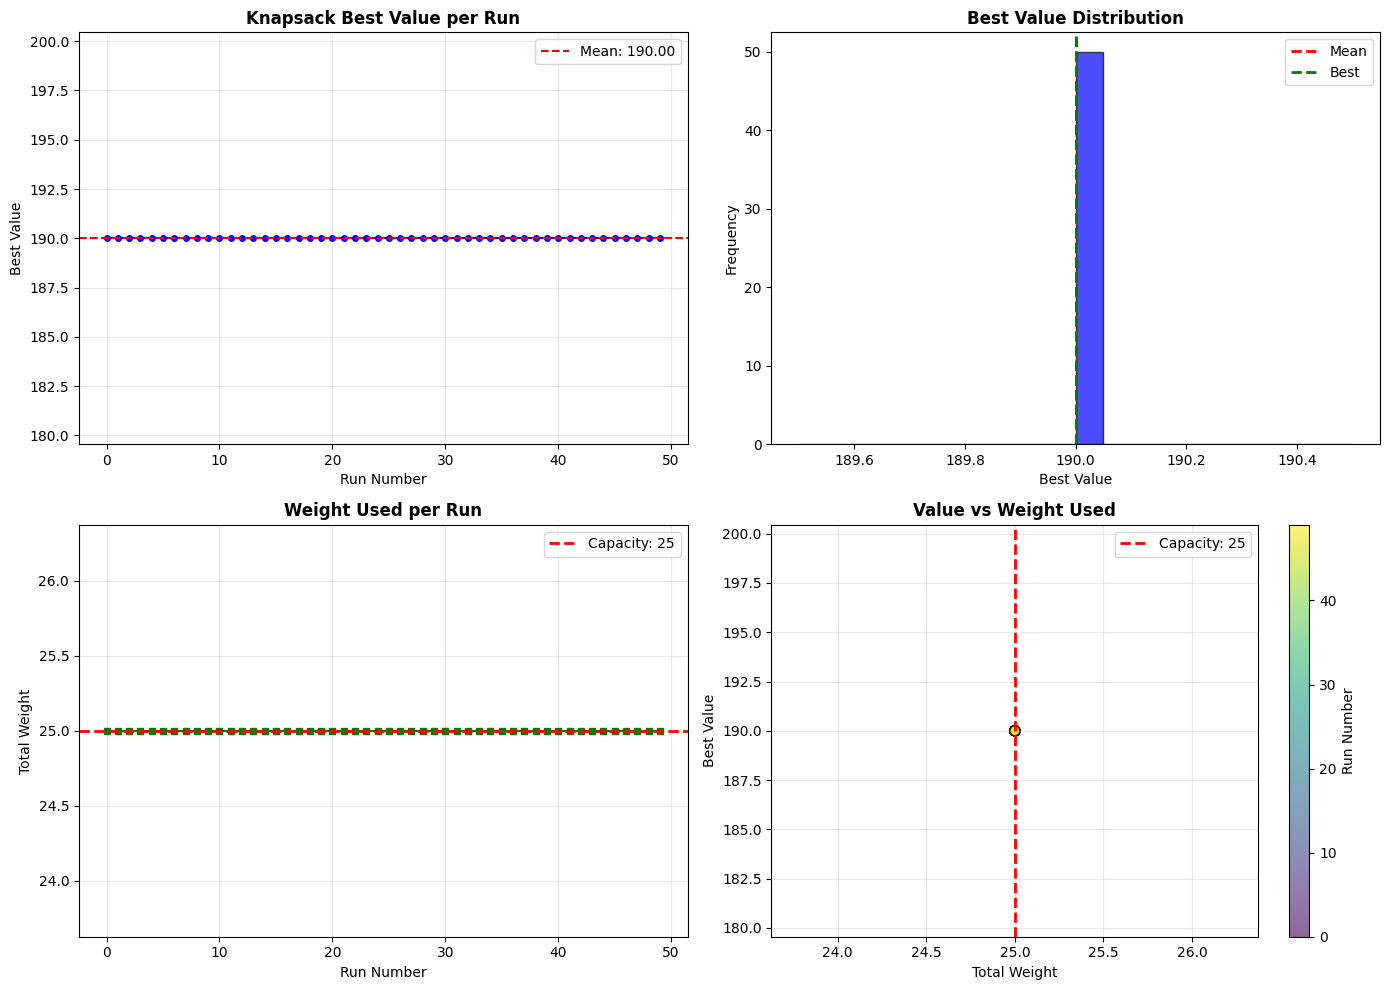


KNAPSACK SUMMARY STATISTICS
Best Value     :   190.00
Worst Value    :   190.00
Mean Value     :   190.00
Std Dev        :     0.00
Best Weight    :    25.00
Mean Weight    :    25.00

Best Solution (Run 0):
  Value: 190
  Weight: 25/25
  Items selected: [1, 1, 0, 0, 0, 1, 0, 0, 1, 1]


In [9]:
def run_knapsack_walks(
    values,
    weights,
    capacity,
    steps: int = 100_000,
    runs: int = 50,
    seed: int = 0,
):
    rng = random.Random(seed)
    results = []

    for run in range(runs):
        run_seed = rng.randint(0, 10**9)
        best_x, best_cost = random_walk_knapsack(values, weights, capacity, steps, seed=run_seed)
        total_v, total_w = knapsack_value_weight(best_x, values, weights)
        results.append((run, best_cost, total_v, total_w, best_x))

    # Extract data for visualization
    run_numbers = [r[0] for r in results]
    best_values = [r[1] for r in results]
    weights_used = [r[3] for r in results]
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Best Value per Run - Line plot
    axes[0, 0].plot(run_numbers, best_values, 'b-', marker='o', markersize=4)
    axes[0, 0].set_title('Knapsack Best Value per Run', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Run Number')
    axes[0, 0].set_ylabel('Best Value')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=np.mean(best_values), color='r', linestyle='--', label=f'Mean: {np.mean(best_values):.2f}')
    axes[0, 0].legend()
    
    # 2. Value Distribution - Histogram
    axes[0, 1].hist(best_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Best Value Distribution', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Best Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(x=np.mean(best_values), color='r', linestyle='--', linewidth=2, label='Mean')
    axes[0, 1].axvline(x=np.max(best_values), color='g', linestyle='--', linewidth=2, label='Best')
    axes[0, 1].legend()
    
    # 3. Weight Used per Run
    axes[1, 0].plot(run_numbers, weights_used, 'g-', marker='s', markersize=4)
    axes[1, 0].axhline(y=capacity, color='r', linestyle='--', linewidth=2, label=f'Capacity: {capacity}')
    axes[1, 0].set_title('Weight Used per Run', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Run Number')
    axes[1, 0].set_ylabel('Total Weight')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # 4. Value vs Weight scatter
    axes[1, 1].scatter(weights_used, best_values, c=run_numbers, cmap='viridis', s=50, alpha=0.6, edgecolors='black')
    axes[1, 1].set_title('Value vs Weight Used', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Total Weight')
    axes[1, 1].set_ylabel('Best Value')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axvline(x=capacity, color='r', linestyle='--', linewidth=2, label=f'Capacity: {capacity}')
    axes[1, 1].legend()
    cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
    cbar.set_label('Run Number')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    stats_data = {
        'Metric': ['Best Value', 'Worst Value', 'Mean Value', 'Std Dev', 'Best Weight', 'Mean Weight'],
        'Value': [
            np.max(best_values),
            np.min(best_values),
            np.mean(best_values),
            np.std(best_values),
            weights_used[best_values.index(max(best_values))],
            np.mean(weights_used)
        ]
    }
    
    if pd is not None:
        stats_df = pd.DataFrame(stats_data)
        print("\n" + "="*60)
        print("KNAPSACK SUMMARY STATISTICS")
        print("="*60)
        display(stats_df)
    else:
        print("\n" + "="*60)
        print("KNAPSACK SUMMARY STATISTICS")
        print("="*60)
        for i, metric in enumerate(stats_data['Metric']):
            print(f"{metric:15s}: {stats_data['Value'][i]:8.2f}")
    
    # Show best solution
    best_idx = best_values.index(max(best_values))
    best_solution = results[best_idx][4]
    print(f"\nBest Solution (Run {best_idx}):")
    print(f"  Value: {results[best_idx][1]}")
    print(f"  Weight: {results[best_idx][3]}/{capacity}")
    print(f"  Items selected: {best_solution}")
    
    return results


# Example call (UNCOMMENT to run; may take time with 100k steps * 50 runs):
knap_results = run_knapsack_walks(values_example, weights_example, capacity_example)
